In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-prediction/seattle-weather.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('/kaggle/input/weather-prediction/seattle-weather.csv')
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


# Visualization

<Axes: xlabel='weather', ylabel='count'>

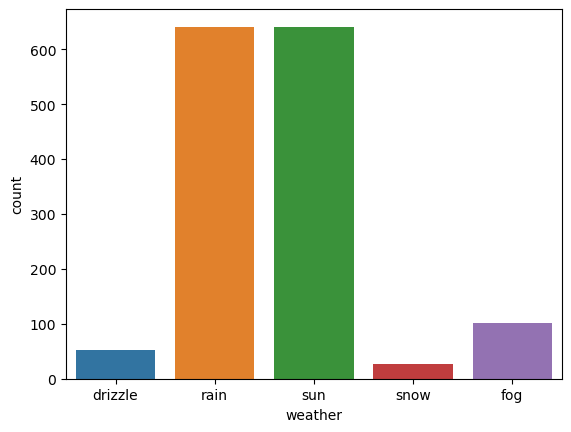

In [4]:
sns.countplot(data=df, x='weather')

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


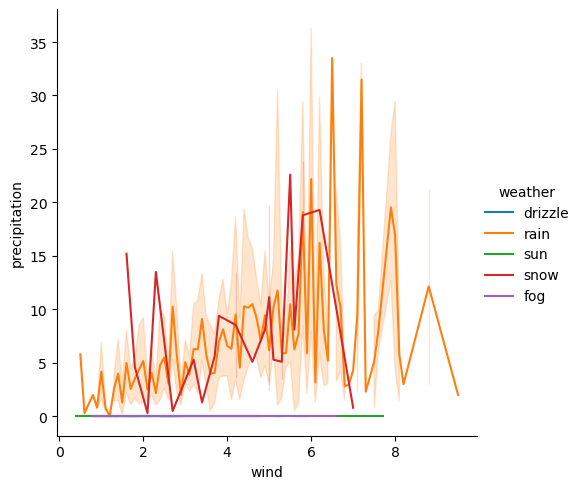

In [5]:
sns.relplot(data=df, x='wind', y='precipitation', hue='weather', kind='line')

<Axes: xlabel='precipitation', ylabel='Count'>

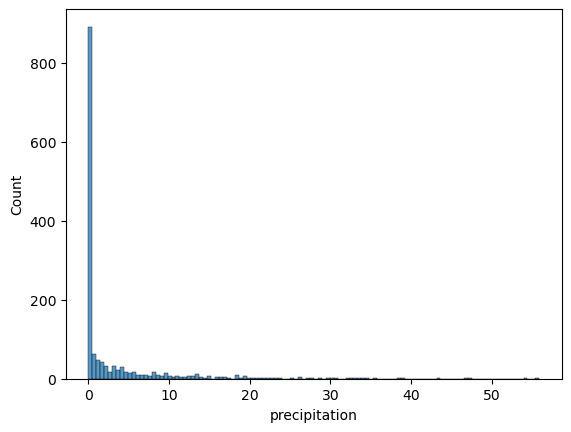

In [6]:
sns.histplot(data=df, x='precipitation')

<Axes: xlabel='temp_max', ylabel='Count'>

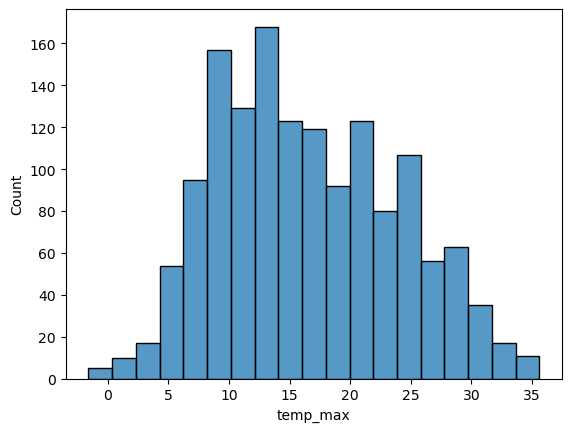

In [7]:
sns.histplot(data=df, x='temp_max')

<Axes: xlabel='temp_min', ylabel='Count'>

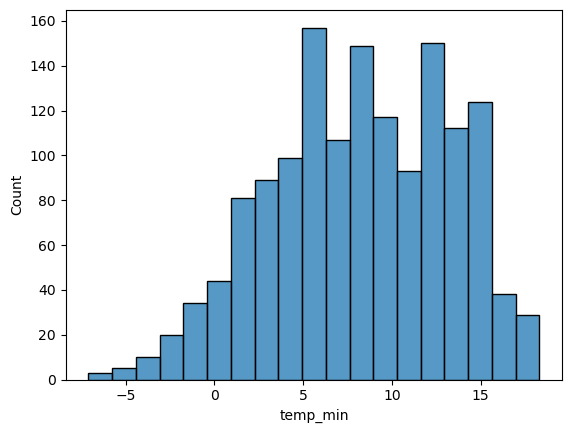

In [8]:
sns.histplot(data=df, x='temp_min')

# Data Manipulation

In [9]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [11]:
df.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [12]:
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun


# Modeling
> ## Pipelining

In [13]:
def models_pipline(X, y, testX, scale):
    
    ## Pipeline
    pip_dtc = Pipeline([('scaler', scale),
                        ('model', DecisionTreeClassifier())]).fit(X, y)
    
    pip_rfc = Pipeline([('scaler', scale),
                        ('model', RandomForestClassifier())]).fit(X, y)
    
    pip_etc = Pipeline([('scaler', scale),
                        ('model', ExtraTreesClassifier())]).fit(X, y)
    
    pip_gbc = Pipeline([('scaler', scale),
                        ('model', GradientBoostingClassifier())]).fit(X, y)
    
    pip_sgdc = Pipeline([('scaler', scale),
                         ('model', SGDClassifier())]).fit(X, y)
    
    pip_knc = Pipeline([('scaler', scale),
                        ('model', KNeighborsClassifier())]).fit(X, y)
    
    pip_mlp = Pipeline([('scaler', scale),
                        ('model', MLPClassifier())]).fit(X, y)
    
    pip_xgb = Pipeline([('scaler', scale),
                        ('model', XGBClassifier())]).fit(X, y)
    
    
    ## Prediction
    pred_dtc = pip_dtc.predict(testX)
    pred_rfc = pip_rfc.predict(testX)
    pred_etc = pip_etc.predict(testX)
    pred_gbc = pip_gbc.predict(testX)
    pred_sgdc = pip_sgdc.predict(testX)
    pred_knc = pip_knc.predict(testX)
    pred_mlp = pip_mlp.predict(testX)
    pred_xgb = pip_xgb.predict(testX)
    
#     predictions = ['pred_dtc', 'pred_rfc', 'pred_etc', 'pred_gbc', 'pred_sgdc', 'pred_knc', 'pred_mlp']
    
    ## Evaluation
    
#     for preds in predictions:
    print(f"DecisionTreeClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_dtc))}\n Accuracy Score: {accuracy_score(y_test, pred_dtc)}\n Classification Report:\n {classification_report(y_test, pred_dtc)}")
    print(f"RandomForestClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_rfc))}\n Accuracy Score: {accuracy_score(y_test, pred_rfc)}\n Classification Report:\n {classification_report(y_test, pred_rfc)}")
    print(f"ExtraTreesClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_etc))}\n Accuracy Score: {accuracy_score(y_test, pred_etc)}\n Classification Report:\n {classification_report(y_test, pred_etc)}")
    print(f"GradientBoostingClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_gbc))}\n Accuracy Score: {accuracy_score(y_test, pred_gbc)}\n Classification Report:\n {classification_report(y_test, pred_gbc)}")
    print(f"SGDClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_sgdc))}\n Accuracy Score: {accuracy_score(y_test, pred_sgdc)}\n Classification Report:\n {classification_report(y_test, pred_sgdc)}")
    print(f"KNeighborsClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_knc))}\n Accuracy Score: {accuracy_score(y_test, pred_knc)}\n Classification Report:\n {classification_report(y_test, pred_knc)}")
    print(f"MLPClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_mlp))}\n Accuracy Score: {accuracy_score(y_test, pred_mlp)}\n Classification Report:\n {classification_report(y_test, pred_mlp)}")
    print(f"XGBClassifier:\n Confusion matrix: {sns.heatmap(confusion_matrix(y_test, pred_xgb))}\n Accuracy Score: {accuracy_score(y_test, pred_xgb)}\n Classification Report:\n {classification_report(y_test, pred_xgb)}")

> ## Data Preparing:

In [14]:
# Encoding the Target which is Categorical in Nature.

le = LabelEncoder()
df['weather'] = le.fit_transform(df['weather'])

In [15]:
df

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,0
1,2012-01-02,10.9,10.6,2.8,4.5,2
2,2012-01-03,0.8,11.7,7.2,2.3,2
3,2012-01-04,20.3,12.2,5.6,4.7,2
4,2012-01-05,1.3,8.9,2.8,6.1,2
...,...,...,...,...,...,...
1456,2015-12-27,8.6,4.4,1.7,2.9,2
1457,2015-12-28,1.5,5.0,1.7,1.3,2
1458,2015-12-29,0.0,7.2,0.6,2.6,1
1459,2015-12-30,0.0,5.6,-1.0,3.4,4


In [16]:
# Splitting the Dataset

X = df.drop(columns=['date', 'weather'])
y = df['weather']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

> ## Testing pipeline functions

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


DecisionTreeClassifier:
 Confusion matrix: Axes(0.125,0.11;0.62x0.77)
 Accuracy Score: 0.7064846416382252
 Classification Report:
               precision    recall  f1-score   support

           0       0.06      0.10      0.07        10
           1       0.24      0.21      0.22        29
           2       0.90      0.90      0.90       123
           3       0.75      0.50      0.60         6
           4       0.70      0.69      0.70       125

    accuracy                           0.71       293
   macro avg       0.53      0.48      0.50       293
weighted avg       0.72      0.71      0.71       293

RandomForestClassifier:
 Confusion matrix: Axes(0.125,0.11;0.496x0.77)
 Accuracy Score: 0.7747440273037542
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.11      0.03      0.05        29
           2       0.97      0.91      0.94       123
           3       1.00      0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier:
 Confusion matrix: Axes(0.125,0.11;0.203162x0.77)
 Accuracy Score: 0.6689419795221843
 Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.10      0.12        10
           1       0.16      0.10      0.12        29
           2       0.78      0.81      0.79       123
           3       1.00      0.17      0.29         6
           4       0.66      0.73      0.69       125

    accuracy                           0.67       293
   macro avg       0.55      0.38      0.40       293
weighted avg       0.65      0.67      0.65       293

MLPClassifier:
 Confusion matrix: Axes(0.125,0.11;0.162529x0.77)
 Accuracy Score: 0.7406143344709898
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        29
           2       0.86      0.83      0.84       123
           3       1.00      0.17  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBClassifier:
 Confusion matrix: Axes(0.125,0.11;0.130023x0.77)
 Accuracy Score: 0.7679180887372014
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.27      0.14      0.18        29
           2       0.93      0.91      0.92       123
           3       1.00      0.17      0.29         6
           4       0.72      0.86      0.79       125

    accuracy                           0.77       293
   macro avg       0.58      0.42      0.43       293
weighted avg       0.75      0.77      0.75       293



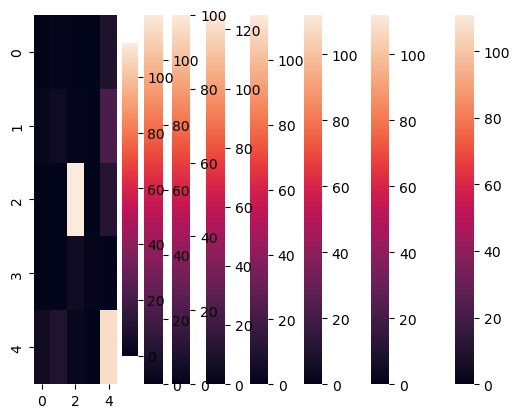

In [17]:
# Calling the pipeline function for testing different models.

sc = StandardScaler() # Using StandardScaler
models_pipline(X_train, y_train, X_test, sc)

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


DecisionTreeClassifier:
 Confusion matrix: Axes(0.125,0.11;0.62x0.77)
 Accuracy Score: 0.689419795221843
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.19      0.17      0.18        29
           2       0.92      0.89      0.91       123
           3       0.60      0.50      0.55         6
           4       0.70      0.67      0.69       125

    accuracy                           0.69       293
   macro avg       0.48      0.45      0.46       293
weighted avg       0.71      0.69      0.70       293

RandomForestClassifier:
 Confusion matrix: Axes(0.125,0.11;0.496x0.77)
 Accuracy Score: 0.7747440273037542
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.09      0.03      0.05        29
           2       0.97      0.91      0.94       123
           3       1.00      0.5

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier:
 Confusion matrix: Axes(0.125,0.11;0.203162x0.77)
 Accuracy Score: 0.6518771331058021
 Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.10      0.13        10
           1       0.27      0.14      0.18        29
           2       0.73      0.78      0.76       123
           3       1.00      0.17      0.29         6
           4       0.63      0.71      0.67       125

    accuracy                           0.65       293
   macro avg       0.57      0.38      0.41       293
weighted avg       0.63      0.65      0.63       293

MLPClassifier:
 Confusion matrix: Axes(0.125,0.11;0.162529x0.77)
 Accuracy Score: 0.7098976109215017
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        29
           2       0.80      0.80      0.80       123
           3       0.00      0.00  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBClassifier:
 Confusion matrix: Axes(0.125,0.11;0.130023x0.77)
 Accuracy Score: 0.764505119453925
 Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.27      0.14      0.18        29
           2       0.93      0.91      0.92       123
           3       1.00      0.17      0.29         6
           4       0.72      0.86      0.78       125

    accuracy                           0.76       293
   macro avg       0.58      0.41      0.43       293
weighted avg       0.75      0.76      0.74       293



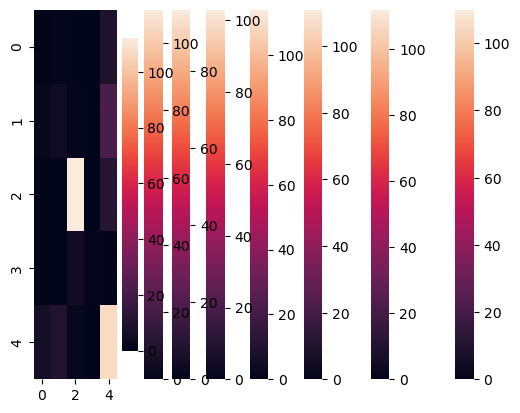

In [18]:
mmsc = MinMaxScaler()
models_pipline(X_train, y_train, X_test, mmsc)

> ## Final to be used and checked are MLP, GBC and RandomForest